# TP Robustness of AI

In [ ]:
!pip install facenet-pytorch

!pip install git+https://github.com/BorealisAI/advertorch.git
!pip install torchvision
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/BorealisAI/advertorch.git to /tmp/pip-req-build-5plh830u
  Running command git clone --filter=blob:none --quiet https://github.com/BorealisAI/advertorch.git /tmp/pip-req-build-5plh830u
  Resolved https://github.com/BorealisAI/advertorch.git to commit e063e341c87d9a621ae1a8f72c3507d5ea5bd327
  Preparing metadata (setup.py) ... done
  Created wheel for advertorch: filename=advertorch-0.2.4-py3-none-any.whl size=5706976 sha256=fb1c147185b0a539c18876cbdee54a1e76df63ff8cac53c19cd2c876235963cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-6qc1gwse/wheels/d1/f3/90/1afd0e205326233b5a675e7b5b8908e551ce2a08f9df81905c
Successfully built advertorch
Looking in indexes: https://pypi.org/simple, 

In [ ]:
import cv2
import torch
import numpy as np
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Facial recognition libraries
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization
from facenet_pytorch import InceptionResnetV1 as resnet

# Adversarial attacks libraries
from advertorch.attacks import MomentumIterativeAttack
from matplotlib import pyplot as plt

## Part 1 - Facial recognition

The goal of this part is for you to practice with  the facial recognition library you will use for the project.

You can use the tutorial / ressources here: https://github.com/timesler/facenet-pytorch


(-0.5, 297.5, 168.5, -0.5)

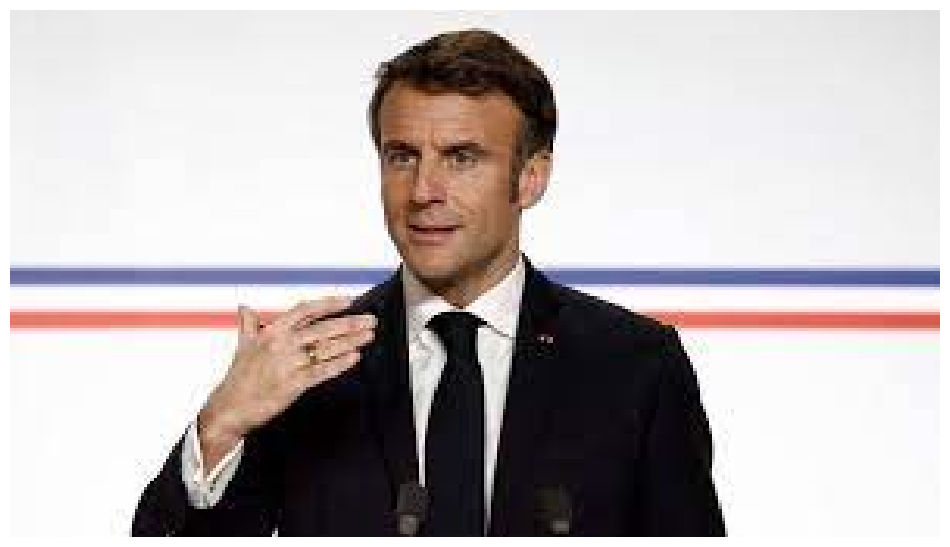

In [ ]:
# Open an image with a face using PIL / numpy
from PIL import Image

img = cv2.imread("/content/ddd.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)

plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
mtcnn = MTCNN(image_size=244, post_process = False) # Load and initialize MTCNN 
img_cropped = mtcnn(img)

resnet.classify = True
img_probs = resnet(img_cropped.unsqueeze(0))


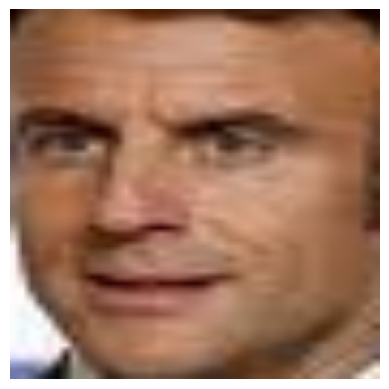

In [ ]:
# Visualize
plt.imshow(img_cropped.permute(1, 2, 0).int().numpy())
plt.axis('off');

In [ ]:
# Use it to detect faces in the picture
# With the boxes plot a square around the detected face
# Extract this part of the picture

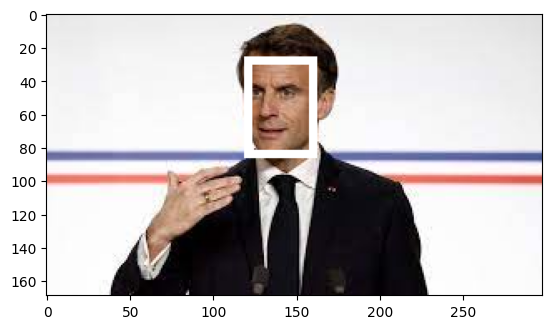

In [ ]:
# Bounding box
from PIL import Image, ImageDraw
from facenet_pytorch import MTCNN, extract_face

boxes, probs, landmarks = mtcnn.detect(img, landmarks=True)

img_draw = img.copy()
draw = ImageDraw.Draw(img_draw)
for i, (box, point) in enumerate(zip(boxes, landmarks)):
    draw.rectangle(box.tolist(), width=5)
    extract_face(img, box, save_path='detected_face_{}.png'.format(i))
img_draw.save('annotated_faces.png')

plt.imshow(Image.open('/content/annotated_faces.png'))

## Part 2 - Adversarial attacks

The goal of this part is for you to practice with the adverarial attack library. You can use the ressources from here: https://github.com/BorealisAI/advertorch

In [ ]:
# Import a pretrained model from pytorch
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from google.colab import files
uploaded = files.upload() # select and upload your file

Saving me2.jpeg to me2.jpeg


In [ ]:
# Load a picture of a cat using pytorch / PIL
from PIL import Image
img = Image.open("/content/chat.jpg")

In [ ]:
# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

In [ ]:
# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

In [ ]:
# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

tiger cat: 26.1%


torch.Size([1, 3, 224, 224])


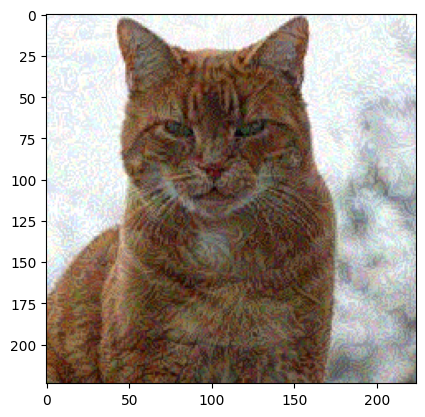

In [ ]:
# Use the adversarial library to transform this cat into a dog for this model
attack = MomentumIterativeAttack (model,loss_fn=lambda p,q: ((p-q)**2).sum(),  eps=0.3,
    nb_iter=100, eps_iter=0.01, clip_min=-5, clip_max=5, targeted=False)

onehot = torch.zeros(1, 1000).contiguous()
onehot[:,123] = 1   # class 123 --> label target of dog, meaning change the image to misclassify as dog
im = preprocess(img)
im = im.reshape(1, *im.shape).float().contiguous()
print(im.shape)

imperturb = attack.perturb(im, onehot)
plotim = imperturb.squeeze().permute(1,2,0)
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

plotim = plotim*std + mean
plotim = plotim.detach().numpy()
plt.imshow(plotim)

In [ ]:
#  Use the model and print the predicted category
prediction = model(imperturb).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

Lakeland terrier: 27.2%
